In [56]:
import cv2
import numpy as np 
import torch 
from torchvision import transforms, models 
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision


In [67]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [69]:
from sklearn.cluster import KMeans

In [57]:
print(cv2.__version__)

4.6.0


In [ ]:
dataset = torchvision.datasets.Caltech101('/Users/niteeqsheik/Desktop/CSE515-Project(Git)',download=True)
data_loader = torch.utils.data.DataLoader(dataset,
batch_size=4,
shuffle=True,
num_workers=8)
print(len(dataset))

131740031it [00:08, 15997173.30it/s]


Extracting /Users/niteeqsheik/Desktop/CSE515-Project(Git)/caltech101/101_ObjectCategories.tar.gz to /Users/niteeqsheik/Desktop/CSE515-Project(Git)/caltech101


14028800it [00:01, 11884240.99it/s]


Extracting /Users/niteeqsheik/Desktop/CSE515-Project(Git)/caltech101/Annotations.tar to /Users/niteeqsheik/Desktop/CSE515-Project(Git)/caltech101
8677


In [58]:
from skimage.io import imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

This is ID:8000
label:92


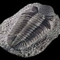

In [23]:
image_ID =8000
img, label = dataset[image_ID]
print(f'This is ID:{image_ID}')
print(f'label:{label}')
newsize = (60, 60)
img = img.resize(newsize)
display(img)

In [71]:
labels_caltech_101 = np.array([dataset[i][1] for i in range(len(dataset))])

In [74]:
print(labels_caltech_101[8676])

100


In [83]:
from PIL import Image
from torchvision import datasets
import torch
import numpy as np
from scipy.stats import skew
import csv
from tqdm import tqdm

# Initialize an empty list to store color moments
color_moments_list = []

# Initialize an empty list to store img_arrays (if needed)
all_img_arrays = []

# Loop through the dataset
for image_ID in tqdm(range(len(dataset))):
    img, label = dataset[image_ID]
    
    # Step 1: Resize the image to 300x100
    new_size = (300, 100)
    img_resized = img.resize(new_size)
    
    # Convert the PIL Image to a NumPy array
    img_array = np.array(img_resized)
    
    #grayscale image check 
    is_gray = len(img_array.shape) == 2
    
    # Append the img_array to the list (if you need to keep all arrays)
    all_img_arrays.append(img_array)

    # Step 2: Partition the image into a 10x10 grid
    for i in range(0, 300, 30):
        for j in range(0, 100, 10):
            grid_cell = img_array[j:j+10, i:i+30]
            
            # Step 3: Calculate the color moments for each grid cell
            color_moments_dict = {}
            for color_channel, color_name in enumerate(['Gray'] if is_gray else ['Red', 'Green', 'Blue']):
                channel_data = grid_cell if is_gray else grid_cell[:, :, color_channel]

                # Calculate mean, standard deviation, and skewness
                channel_mean = np.mean(channel_data)
                channel_std = np.std(channel_data)
                if np.all(channel_data == channel_data[0]):
                    channel_skewness = 0
                else :
                    channel_skewness = skew(channel_data.reshape(-1))
                
                # Store the color moments in the dictionary
                color_moments_dict[f"{color_name}_Mean"] = channel_mean
                color_moments_dict[f"{color_name}_Std"] = channel_std
                color_moments_dict[f"{color_name}_Skewness"] = channel_skewness
            
            # Include the ImageID
            color_moments_dict["ImageID"] = image_ID
            
            # Append the color moments to the list
            color_moments_list.append(color_moments_dict)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8677/8677 [12:03<00:00, 11.99it/s]


In [84]:
print(len(color_moments_list))

867700


In [24]:
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans

In [26]:
from tqdm import tqdm

In [86]:
# import pandas as pd 
# df_color_moments = pd.read_csv("color_moments_with_imageID.csv")

In [85]:
# print(len(df_color_moments))

In [87]:
# feature_columns = df_color_moments.columns[1:-1]
# data_color_moments = df_color_moments[feature_columns].values

In [88]:
# print(feature_columns)

In [89]:
# print(data_color_moments[0]) 

In [44]:
from sklearn.decomposition import TruncatedSVD

In [50]:
# k = 5 
# svd = TruncatedSVD(n_components = k)
# latent_semantics = svd.fit_transform(data_color_moments)
# print("Reduced Data:(Latent Semantics)")
# print(latent_semantics)

In [49]:
def SVD_calc(feature_matrix,k):
    svd = TruncatedSVD(n_components=k)
    latent_semantics = svd.fit_transform(feature_matrix)
    return latent_semantics

In [51]:
from sklearn.decomposition import NMF 

In [52]:
def NMF_calculator(feature_matrix,k):
    nmf = NMF(n_components=k)
    W = nmf.fit_transform(feature_matrix)
    H = nmf.components_
    return H 

In [68]:
def LDA_calculator(feature_matrix,k):
    lda = LinearDiscriminantAnalysis(n_components = k)
    lda_result = lda.fit_transform(feature_matrix,labels_caltech_101)
    top_k_latent = lda.components_[:k]
    return top_k_latent
    

In [75]:
def k_means_calculator(feature_matrix,k):
    kmeans = KMeans(n_clusters = k,random_state=0)
    kmeans.fit(feature_matrix)
    top_k_latent_semantics = kmeans.cluster_centers_
    return top_k_latent_semantics

## Below Is the Code Of Block of converting the Phase 1 results into feature matrices

In [94]:
# import pandas as pd 
# df_color_moments = pd.read_csv("color_moments_with_imageID.csv")
# feature_columns = df_color_moments.columns[1:-1]
# data_color_moments = df_color_moments[feature_columns].values
# print(feature_columns)
# print(data_color_moments[0]) 

#### In the Below code block use data_color_moments as the feature matrix for SVD 
#### Use the X_color_moments for LDA 

In [98]:

import pandas as pd 
color_moments_df = pd.DataFrame(color_moments_list)
data_color_moments= color_moments_df.drop(columns="ImageID").to_numpy()
n_grids_per_image = 10 * 10  # 10x10 grid for each image
n_features_per_grid = data_color_moments.shape[1]
X_color_moments = data_color_moments.reshape(len(dataset), n_grids_per_image * n_features_per_grid)


In [100]:
print(len(X_color_moments))

8677


##  Create the UI here and call appropriate functions


In [106]:
k = input("Enter value of k")
k = int(k)
#Select the Feature model
#Select the Dimensionality Reduction Technique 


<class 'int'>
34
